Attempt to extract parameters using Theo's Method


In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
    
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

Time domain sampling: 2425


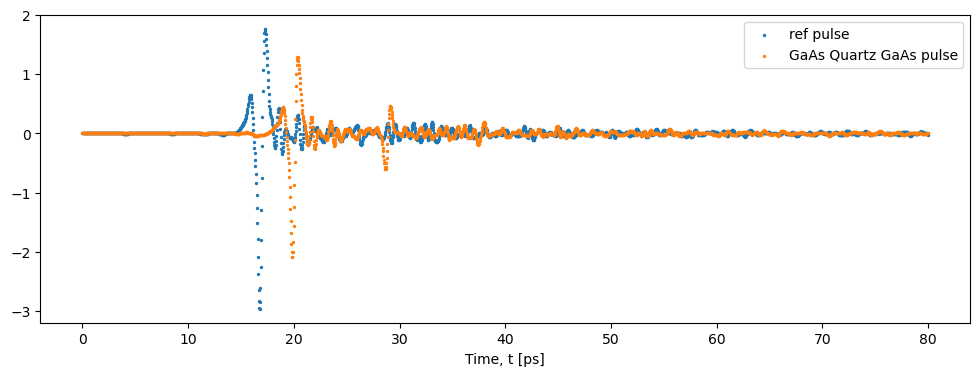

In [2]:
# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_04_02_2026\reference_pulse.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_HRZ_Si = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_04_02_2026\HRZ_Si_380um.txt",dtype=float)

t1= reference_pulse[:,0] + 740  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 = sample_pulse_HRZ_Si[:,0] + 740  # ADJUISTING THE AXIS
amp2 = sample_pulse_HRZ_Si[:,1]
time_axis_ref = t1
ref_pulse = amp1
time_axis_sample = t2
sample_pulse = amp2

#sample_pulse -= bias

## Known parameters
d = 380e-6

L = len(ref_pulse)
print(f'Time domain sampling: {L}')

# Structure: [GaAs-Quartz-GaAs]

plt.figure(figsize=(12,4))
plt.scatter(time_axis_ref, ref_pulse, label='ref pulse', s=2)
plt.scatter(time_axis_sample, sample_pulse, label='GaAs Quartz GaAs pulse', s=2)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [3]:
## Check time steps are consistent in t_axis
# Compute time differences between consecutive samples
dt = np.diff(time_axis_ref)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

deltat = np.mean(dt)
deltat = deltat * 1e-12  # Convert to seconds for calculations

Time steps are uniform: False
Min dt: 0.03300329999990481
Max dt: 0.033003309999912744
Mean dt: 0.033003300330033


Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.2600000000000002, 3.86)
Layer 1 - k ∈ (-0.02, 0.0)
Layer 1 - D ∈ (0.00018999999999999998, 0.00059)
Bayes params: [((3.2600000000000002+0j), 0.0004082175236296898)]


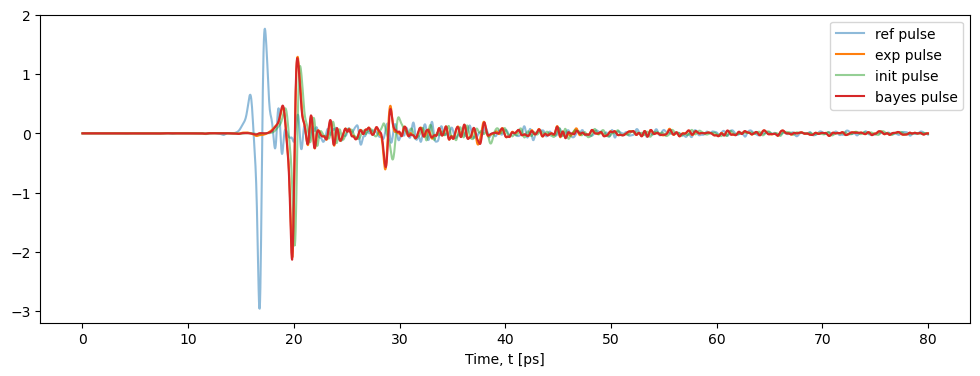

In [4]:
# Convert ref to torch tensor 
ref_pulse_t = torch.tensor(ref_pulse, dtype=torch.float32) 
sample_pulse_t = torch.tensor(sample_pulse, dtype=torch.float32) 

# Initial guesses
n_HRZ = 3.56
k_HRZ = -0.01
d_HRZ = 390e-6


optimize_mask = [
    (True, True, True),  # HRZ Si
   
]

init_guess = [
   
    ((n_HRZ + 1j*k_HRZ), d_HRZ),  # HRZ_Si
]

init_pulse = simulate_parallel(ref_pulse_t, init_guess, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

Bayes_model = BayesianLayeredExtractor(ref_pulse_t, sample_pulse_t, deltat=deltat, layers_init=init_guess, optimize_mask=optimize_mask)
bayes_params = Bayes_model.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(ref_pulse_t, bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params}')
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, init_pulse, label='init pulse', alpha = 0.5)
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 3 parameters for 600 iterations.
Iteration 49, Loss: 8.747051e-03, Layer 0: n=3.3486, k=0.00023, D=395.10 µm
Iteration 99, Loss: 6.231132e-03, Layer 0: n=3.3767, k=0.00101, D=390.92 µm
Iteration 149, Loss: 6.437176e-03, Layer 0: n=3.3768, k=0.00103, D=390.83 µm
Iteration 199, Loss: 6.242305e-03, Layer 0: n=3.3767, k=0.00102, D=390.88 µm
Iteration 249, Loss: 6.230802e-03, Layer 0: n=3.3768, k=0.00101, D=390.91 µm
Iteration 299, Loss: 6.346613e-03, Layer 0: n=3.3765, k=0.00103, D=390.81 µm
Iteration 349, Loss: 6.336426e-03, Layer 0: n=3.3766, k=0.00103, D=390.84 µm
Iteration 399, Loss: 6.407561e-03, Layer 0: n=3.3765, k=0.00105, D=390.82 µm
Iteration 449, Loss: 6.410488e-03, Layer 0: n=3.3765, k=0.00112, D=390.82 µm
Iteration 499, Loss: 6.411895e-03, Layer 0: n=3.3765, k=0.00127, D=390.82 µm
Iteration 549, Loss: 6.414637e-03, Layer 0: n=3.3765, k=0.00129, D=390.82 µm
Iteration 599, Loss: 6.416242e-03, Layer 0: n=3.3765, k=0.00130, D=390.82 µm
[((3.3767402172088623+0.001017651

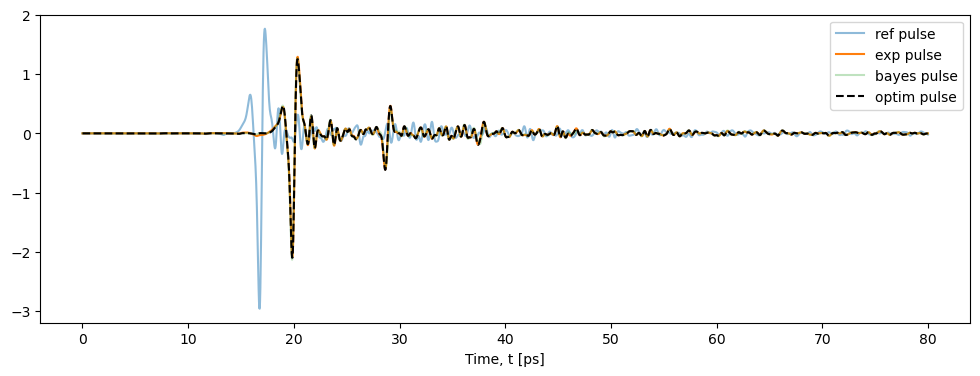

In [5]:
grad_optimizer = LayeredExtractor(ref_pulse_t, sample_pulse_t, deltat, bayes_params, optimize_mask, lr=0.01)
optim_params = grad_optimizer.optimize(num_iterations=600, updates=50, alpha=1)



optim_pulse = simulate_parallel(ref_pulse_t, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse', alpha = 0.3)
plt.plot(time_axis_sample, optim_pulse, label='optim pulse',linestyle='--' ,color='black' )
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [6]:
optim_params

[((3.3767402172088623+0.0010176515206694603j), 0.00039091621874831617)]

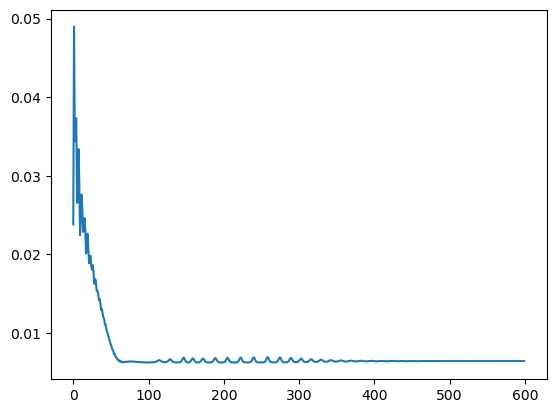

In [7]:
plt.plot(grad_optimizer.loss_history)